In [1]:
from __future__ import print_function, division
from builtins import range
import gym
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime

In [2]:
# turns list of integers into an int
# Ex.
# build_state([1,2,3,4,5]) -> 12345
def build_state(features):
    return int("".join(map(lambda feature: str(int(feature)), features)))

In [3]:
def to_bin(value, bins):
    return np.digitize(x= [value], bins= bins)[0]

In [11]:
class FeatureTransformer:
    def __init__(self):
        # Note: to make this better you could look at how often eac bin was
        # actually used while running the script.
        # It's no clear from the high/low values nor sample() what values
        # we really expect to get.
        self.cart_position_bins = np.linspace(-2.4, 2.4, 9)
        self.cart_velocity_bins = np.linspace(-2, 2, 9) # (-inf, inf) I did not check that these were good values)
        self.pole_angle_bins = np.linspace(-0.4, 0.4, 9)
        self.pole_velocity_bins = np.linspace(-3.5, 3.5, 9) # (-inf, inf) I did not check that these were good values)
        
    def transform(self, observation):
        # returns an int
        cart_pos, cart_vel, pole_angle, pole_vel = observation
        return build_state([
            to_bin(cart_pos, self.cart_position_bins),
            to_bin(cart_vel, self.cart_velocity_bins),
            to_bin(pole_angle, self.pole_angle_bins),
            to_bin(pole_vel, self.pole_velocity_bins)
        ])
        

In [5]:
class Model:
    def __init__(self, env, feature_transformer):
        self.env = env
        self.feature_transformer = feature_transformer
        
        num_states = 10**env.observation_space.shape[0]
        num_actions = env.action_space.n
        self.Q = np.random.uniform(low= -1, high= 1, size= (num_states, num_actions))
        
    def predict(self, s):
        x = self.feature_transformer.transform(s)
        return self.Q[x] #return an array of actions
        
    def update(self, s, a, G):
        x = self.feature_transformer.transform(s)
        self.Q[x,a] += 10e-5 * (G - self.Q[x,a]) # update Q with gradient-descent
        
    def sample_action(self, s, eps): # epsilon-greedy
        if np.random.random() < eps:
            return self.env.action_space.sample()
        else:
            p = self.predict(s)
            return np.argmax(p)

In [13]:
# returns a list of states_and_rewards, an the total reward
def play_one(model, eps, gamma):
    # gamma: discount rate
    observation = env.reset()
    done = False
    totalreward = 0
    iters = 0
    while not done and iters < 10000:
        action = model.sample_action(observation, eps)
        prev_observation = observation
        observation, reward, done, info = env.step(action)
        
        totalreward += reward
        
        if done and iters < 199:
            rewards = -300
            
        # update the model
        G = reward + gamma * np.max(model.predict(observation))
        model.update(prev_observation, action, G)
        
        iters += 1
        
    return totalreward

In [8]:
def plot_running_avg(totalrewards):
    N = len(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = totalrewards[max(0, t - 100):(t+1)].mean()
    plt.plot(running_avg)
    plt.title("Running Average")
    plt.show()

[2017-10-14 14:32:37,420] Making new env: CartPole-v0


episode: 0 total reward: 14.0 eps: 1.0
episode: 1000 total reward: 40.0 eps: 0.0316069770621
episode: 2000 total reward: 45.0 eps: 0.0223550917005
episode: 3000 total reward: 110.0 eps: 0.0182543764409
episode: 4000 total reward: 18.0 eps: 0.0158094122478
episode: 5000 total reward: 36.0 eps: 0.0141407216223
episode: 6000 total reward: 24.0 eps: 0.0129088687931
episode: 7000 total reward: 21.0 eps: 0.0119514324501
episode: 8000 total reward: 21.0 eps: 0.0111796411818
episode: 9000 total reward: 133.0 eps: 0.0105403399757
avg reward for last 100 episodes: 49.58
total steps: 455214.0


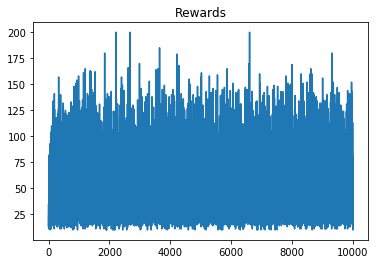

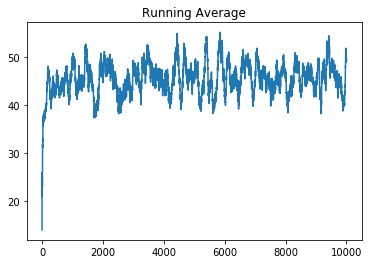

In [16]:
if __name__ == '__main__':
    env = gym.make('CartPole-v0')
    ft = FeatureTransformer()
    model = Model(env, ft)
    gamma = 0.9
    
    if 'monitor' in sys.argv:
        filename = os.path.basename(__file__).split('.')[0]
        monitor_dir = './' + filename + '_' + str(datetime.now())
        env = wrappers.Monitor(env, monitor_dir)
        
    N = 10000
    totalrewards = np.empty(N)
    for n in range(N):
        eps = 1.0/np.sqrt(n + 1)
        totalreward = play_one(model, eps, gamma)
        totalrewards[n] = totalreward
        if n % 1000 == 0:
            print("episode:", n, "total reward:", totalreward, "eps:", eps)
    print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
    print("total steps:", totalrewards.sum())
    
    plt.plot(totalrewards)
    plt.title("Rewards")
    plt.show()
    
    plot_running_avg(totalrewards)